In [2]:
import numpy as np #numpy for math operation
import os
import utils
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
# from time import time
from tqdm import tqdm
import cv2
from natsort import natsorted
from pydicom import dcmread
import pickle
import matplotlib.gridspec as gridspec
from matplotlib.colors import hsv_to_rgb,rgb_to_hsv
from multiprocessing import Pool, shared_memory
import h5py
# data_path = '/Users/akapatil/Documents/OCT/timelapse/inter_volume_registered/Timelapse_with_H2O2/registered_cropped_bottom'
average_LivCurve = True
fitting_method = "CPU"
frameSeparationTime = 0.001 #1ms frame to frame time interval
alivInitial  = 1 #initla guess for aliv parameter curve fitting
swiftInitial = 1 # initial guess for swiftness parameter curve fitting
bounds = (0, np.inf)
# save_dcm_pickle(data_path)

put everything in a scan in a pickle file 

In [39]:
# scan_name = natsorted(os.listdir(data_path))[10]
# dcm_name = natsorted(os.listdir(os.path.join(data_path, scan_name)))[0]

# ds = dcmread(os.path.join(data_path, scan_name, dcm_name))
# arr = ds.pixel_array
# plt.imshow(arr, cmap="gray")

In [40]:
# with open(os.path.join(data_path, scan_name, f'{scan_name}.pickle'), 'rb') as handle:
#     volume = pickle.load(handle)

# plt.imshow(volume[1, :, :], cmap="gray")

In [41]:
data_path = '/Users/akapatil/Documents/OCT/IR_card_glass_side_3_13_2025/intervolume_registered/self_inter'

In [42]:
def load_h5_data(path_scan):
    path = path_scan
    with h5py.File(path, 'r') as hf:
        data = np.array(hf['volume'])
    return first_frame, enface

def load_nested_data_h5(path):
    pic_paths = []
    for scan_num in natsorted(os.listdir(path)):
        if scan_num.startswith('scan'):
            pic_paths.append(os.path.join(path,scan_num,f'{scan_num}.h5'))

    with h5py.File(pic_paths[0], 'r') as hf:
        b = np.array(hf['volume'])
    data = np.zeros((len(pic_paths),b.shape[0],b.shape[1],b.shape[2]))
    for idx,img_path in enumerate(pic_paths):
        with h5py.File(img_path, 'r') as hf:
            temp = np.array(hf['volume'])
        data[idx]=(temp.copy())
    return data

In [43]:
image_list = os.listdir(data_path)#list all images address in data_path
# fourD_image_volume_complete = utils.load_nested_data_pickle(data_path, len(image_list))#load all image volume and combine them in one 4D np array
fourD_image_volume_complete = load_nested_data_h5(data_path)
fourD_image = fourD_image_volume_complete[:20, :, 50:51, :]

In [44]:
fourD_image-=fourD_image.min()

In [45]:
# os.makedirs('test',exist_ok=True)
# for i,j in tqdm(enumerate(fourD_image_volume_complete)):
#     cv2.imwrite(f'test/'+f'frame_test{i}.PNG',j[:,50,:])

In [46]:
# plt.imshow(fourD_image[10,:,5,:])

In [47]:
concatenate_set = utils.concatenate_scan_set(fourD_image)

blockRepeat = fourD_image.shape[0]
blockPerVolume = 1 #only 1 block is used in our protocal
bscanLocationPerBlock = fourD_image.shape[1] #the number of B-scan in one 3D volume

numLocation = bscanLocationPerBlock * blockPerVolume # Number of total B-scan

# print('Processing: ' + data_path)

## OCT intensity
height = concatenate_set.shape[1]
width = concatenate_set.shape[2]

aliv = np.zeros((numLocation, height, width))
swift = np.zeros((numLocation, height, width))
oct_db = np.zeros((numLocation, height, width))

In [48]:
for floc in tqdm(range(0,numLocation), position=0, leave=True):

    # print(floc)
    sparseSequence, timePoints, frameindex = utils.makeSparseDataFromRasterRepeat(concatenate_set, bscanLocationPerBlock, blockRepeat, floc)


    if floc == 0: #for save VLIV array
        VLIV_save = np.zeros((numLocation, timePoints.shape[0]-1, height, width))
    
    oct_db[floc] = 10*np.log10(np.nanmean(sparseSequence + 1e-8, axis=0))
    
    ## Compute VLIV
    VLIV , possibleMtw , VoV = utils.computeVLIV(sparseSequence, timePoints, maxTimeWidth =  np.nan, compute_VoV = False)
    
    ## Average LIV curve
    if average_LivCurve == True:
        twIdx = 0
        for twIdx in range(0, VLIV.shape[0]):                
            VLIV[twIdx,:,:] = cv2.blur(VLIV[twIdx,:,:], (3,3))
            twIdx = twIdx + 1

    
    if fitting_method == 'CPU':
        mag, tau = utils.vlivCPUFitExp(VLIV, possibleMtw, frameSeparationTime, alivInitial, swiftInitial, bounds, use_constraint = False)

    aliv[floc] = mag ## aLIV
    swift[floc] = 1/ tau ## Swiftness
    VLIV_save[floc,:,:,:] = VLIV ## LIV curve (VLIV)
        

  0%|          | 0/500 [00:00<?, ?it/s]/Users/akapatil/opt/anaconda3/envs/ImageProc_2/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/akapatil/Documents/dynamicOCT/utils.py:151: RuntimeWarning: overflow encountered in exp
  return np.absolute(a) * (1 - np.exp(-Tw / tau))
  0%|          | 1/500 [00:00<01:41,  4.90it/s]/Users/akapatil/Documents/dynamicOCT/utils.py:151: RuntimeWarning: overflow encountered in multiply
  return np.absolute(a) * (1 - np.exp(-Tw / tau))
100%|██████████| 500/500 [01:09<00:00,  7.19it/s]


In [49]:
# with open(os.path.join(data_path, "swift_Yusuno.npy"), "wb") as f:
#     np.save(f, swift)

# with open(os.path.join(data_path, "aliv_Yusuno.npy"), "wb") as f:
#     np.save(f, aliv)

# with open(os.path.join(data_path, "VLIV.npy"), "wb") as f:
#     np.save(f, VLIV_save)

In [50]:
slice_index = 0
swift_slice = swift[:, slice_index, :]
swift_slice[swift_slice > np.percentile(swift_slice, 95)] = np.median(swift_slice)
swift_normalized = cv2.normalize(swift_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.float64)
fourD_normalized = cv2.normalize(fourD_image[10, :, slice_index, :], None, 0, 255, cv2.NORM_MINMAX).astype(np.float64)

# plt.figure(figsize=(16, 8))
# gs1 = gridspec.GridSpec(1, 3)
# gs1.update(wspace = 0.025, hspace = 0.05)

# ax1 = plt.subplot(gs1[0])
# plt.axis('on')
# ax1.imshow(fourD_normalized, cmap="gray")
# ax1.set_aspect('equal')
# ax2 = plt.subplot(gs1[1])
# plt.axis('on')
# ax2.imshow(swift_normalized, cmap="inferno")
# ax2.set_aspect('equal')
# ax3 = plt.subplot(gs1[2])
# plt.axis('on')
# ax3.imshow(fourD_normalized, cmap="gray")
# ax3.imshow(swift_normalized, cmap="inferno", alpha=0.5)
# ax1.set_aspect('equal')
# plt.show()

add color to swift and aliv use Dr Yusuno's way

In [51]:
cv2.cvtColor(np.dstack((0,1,1)).astype(np.float32), cv2.COLOR_HSV2RGB)

array([[[1., 0., 0.]]], dtype=float32)

In [52]:
# shm = shared_memory.SharedMemory(create=True, size=fourD_image_volume_complete.nbytes)
# shared_data = np.ndarray(fourD_image_volume_complete.shape, dtype=fourD_image_volume_complete.dtype, buffer=shm.buf)
# np.copyto(shared_data, fourD_image_volume_complete)


# window_size = 20
# num_vols = fourD_image_volume_complete.shape[0] if fourD_image_volume_complete.shape[0] % 2 == 0 else fourD_image_volume_complete.shape[0] + 1
# masks_shape = ((num_vols - window_size) // 2, fourD_image_volume_complete.shape[1], fourD_image_volume_complete.shape[2], fourD_image_volume_complete.shape[3])
# masks = np.zeros(masks_shape, dtype=np.float64)

# tasks = []
# for batch in range(0, fourD_image_volume_complete.shape[0] - window_size, 2):
#     tasks.append((batch, shm.name, window_size, fourD_image_volume_complete.shape))

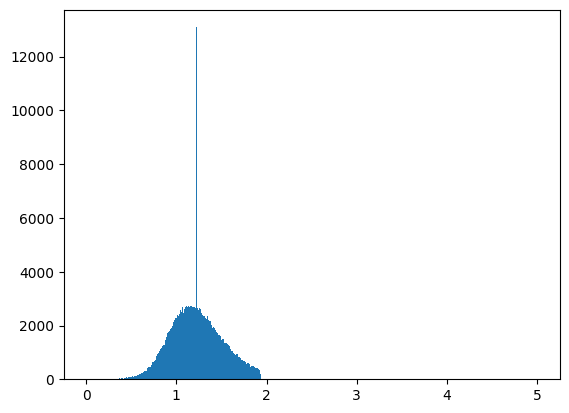

In [53]:
plt.hist(swift.flatten(),bins=500,range=(0,5))
# plt.xlim(0,10)
plt.show()

In [54]:
def generate_RgbImage(doct, dbInt, doctRange, octRange, scale):
    h = utils.scale_clip(doct, *doctRange, scale)
    # h = np.where(h>0.5,h.max(),h)

    hsvImage = np.stack([h, np.ones_like(doct),
                       utils.scale_clip(dbInt, *octRange)], axis=-1)
    rgbImage = hsv_to_rgb(hsvImage)
    # print(utils.scale_clip(doct, *doctRange, scale))
    return rgbImage, h.flatten()

In [55]:
# swift[-1,0,-1] = 100

In [56]:
aliv.max()

179.17733395375487

In [57]:
octRange = (np.min(oct_db), np.max(oct_db))
alivRange = (0, 0.1)
swiftRange = (0, 3)
# swiftRange = (np.min(swift), np.max(swift))

# mod_swift = np.copy(swift)
# mod_swift[mod_swift > np.percentile(mod_swift, 10)] = np.median(mod_swift)
aliv_rgb,aliv_hue = generate_RgbImage(doct = aliv, dbInt = oct_db, doctRange = alivRange, octRange = octRange, scale=0.7)
swift_rgb,hue = generate_RgbImage(doct = swift, dbInt = oct_db, doctRange = swiftRange, octRange = octRange, scale=0.7)

In [58]:
octRange

(8.70056386722114, 27.604849619681048)

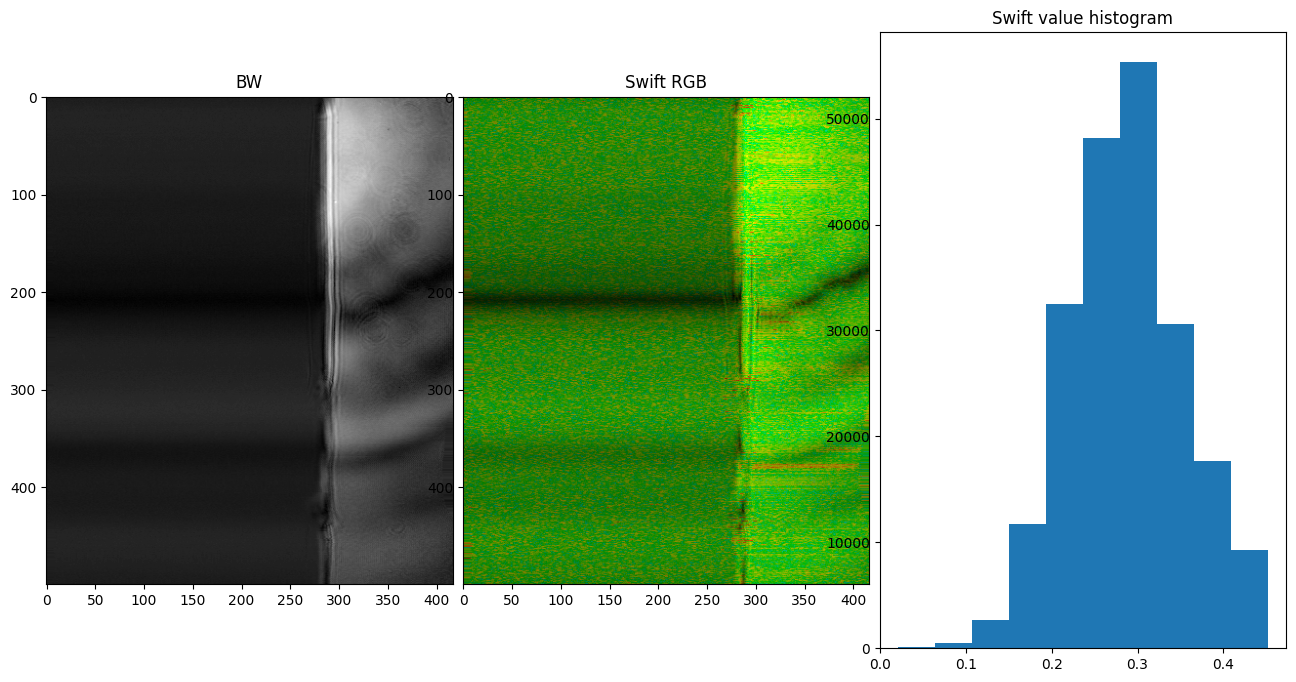

In [59]:
swift_rgb_slice = swift_rgb[:, slice_index, :]
plt.figure(figsize=(16, 8))
gs1 = gridspec.GridSpec(1, 3)
gs1.update(wspace = 0.025, hspace = 0.05)

ax1 = plt.subplot(gs1[0])
plt.axis('on')
ax1.set_title('BW')
ax1.imshow(fourD_normalized, cmap="gray")
ax1.set_aspect('equal')
ax2 = plt.subplot(gs1[1])
plt.axis('on')
ax2.set_title('Swift RGB')
ax2.imshow(swift_rgb_slice)
ax2.set_aspect('equal')
ax3 = plt.subplot(gs1[2])
plt.axis('on')
ax3.set_title('Swift value histogram')
ax3.hist(hue)
# ax3.imshow(swift_rgb_slice, alpha=0.5)
# ax1.set_aspect('equal')
plt.show()

In [60]:
aliv_rgb_slice = aliv_rgb[:, 2, :]
plt.figure(figsize=(16, 8))
gs1 = gridspec.GridSpec(1, 3)
gs1.update(wspace = 0.025, hspace = 0.05)

ax1 = plt.subplot(gs1[0])
plt.axis('on')
ax1.set_title('BW')
ax1.imshow(fourD_normalized, cmap="gray")
ax1.set_aspect('equal')
ax2 = plt.subplot(gs1[1])
plt.axis('on')
ax2.set_title('aliv RGB')
ax2.imshow(aliv_rgb_slice)
ax2.set_aspect('equal')
ax3 = plt.subplot(gs1[2])
plt.axis('on')
ax3.set_title('aliv value histogram')
ax3.hist(aliv_hue)
# ax3.imshow(aliv_rgb_slice, alpha=0.5)
# ax1.set_aspect('equal')
plt.show()

IndexError: index 2 is out of bounds for axis 1 with size 1

In [118]:
k = rgb_to_hsv(swift_rgb_slice)
k[:,:,0] = np.where(k[:,:,0]<0.5,0,k[:,:,0])
kk = hsv_to_rgb(k)

In [37]:
plt.imshow(kk)

NameError: name 'kk' is not defined

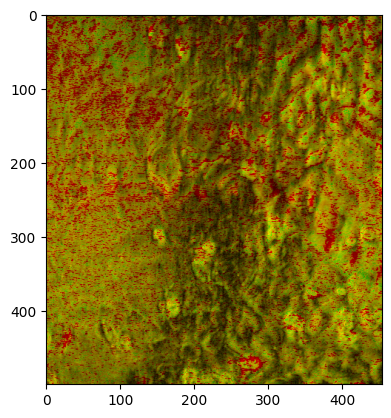

In [178]:
plt.imshow(swift_rgb_slice)

(0.0, 250.0)

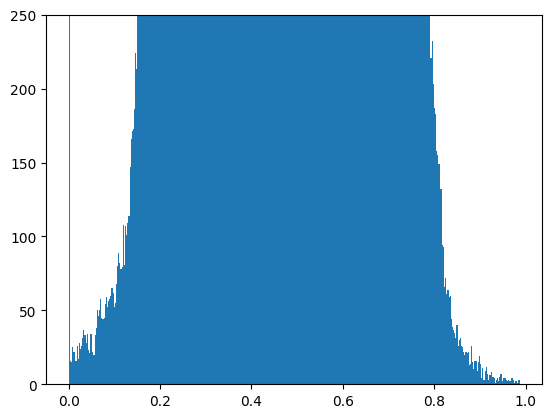

In [195]:
# clipped = np.clip(swift_normalized,)
plt.hist(swift_rgb_slice.flatten(),bins=400)
plt.ylim(0,250)

check the LIV curve with fitted LIV curve

In [36]:
cord = [200, 5, 200]#coordinate
time = possibleMtw
mag = aliv[cord[0], cord[1], cord[2]]
tau = 1 / swift[cord[0], cord[1], cord[2]]
fit_LIV = utils.LIV_fun(possibleMtw*frameSeparationTime, mag, tau)
plt.plot(possibleMtw*frameSeparationTime, VLIV_save[cord[0], :, cord[1], cord[2]], color = "blue")
plt.plot(possibleMtw*frameSeparationTime, fit_LIV, color = "orange")
plt.xlabel("Tw")
plt.ylabel("AVG_LIV")
plt.show()

NameError: name 'possibleMtw' is not defined

In [6]:
with open('/Users/akapatil/Documents/dynamicOCT/swift/IR_noshift_standard_inter/aliv_rgb_IR_noshift_standard_inter.pickle', 'rb') as f:
    data = pickle.load(f)

In [7]:
def flip_hsv(data):
    hsv_data = rgb_to_hsv(data)
    hsv_data[...,0] = np.abs(hsv_data[...,0]-0.7)
    rgb_data = hsv_to_rgb(hsv_data)
    return rgb_data

In [ ]:
# data = flip_hsv(data)
# with open("/Users/akapatil/Documents/dynamicOCT/swift/IR_noshift_standard_inter/aliv_rgb_IR_noshift_standard_inter.pickle", "wb") as file:
#     pickle.dump(data, file)

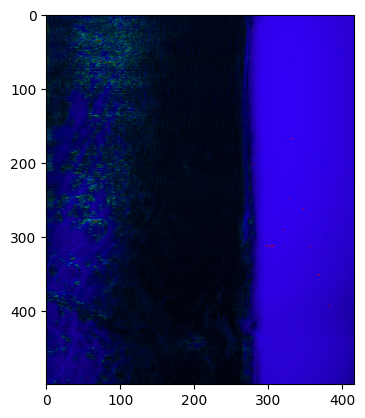

In [35]:
plt.imshow(data[2,:,2])

In [19]:
np.abs(rgb_to_hsv(data)[...,0]-0.7)

array([[[[0.67127508, 0.67146099, 0.66778678, ..., 0.69395548,
          0.69183247, 0.69311816],
         [0.67468702, 0.67458763, 0.67124883, ..., 0.69558368,
          0.69428786, 0.69502396],
         [0.686693  , 0.68660665, 0.68572361, ..., 0.69739786,
          0.6965327 , 0.6971648 ],
         [0.68953904, 0.68940445, 0.68828066, ..., 0.69903066,
          0.69898756, 0.69907413]],

        [[0.68866128, 0.68866128, 0.68866128, ..., 0.62543498,
          0.62744483, 0.62864653],
         [0.68843561, 0.68843561, 0.68843561, ..., 0.61982809,
          0.62182367, 0.62310478],
         [0.68697489, 0.68697489, 0.68697489, ..., 0.61310262,
          0.61308426, 0.61380038],
         [0.68674922, 0.68674922, 0.68674922, ..., 0.60749573,
          0.60746309, 0.60825862]],

        [[0.68657684, 0.68308125, 0.68916996, ..., 0.69243578,
          0.69397267, 0.69284341],
         [0.6890884 , 0.68648069, 0.69189579, ..., 0.6938733 ,
          0.69550738, 0.69479491],
         [0.6963